In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import os
import acquire
from env import host, user, password

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# <font color=“brown”>Goal</font>

**My goal is to predict the values of single unit properties using the obervations from 2017 AKA the column  taxvaluedollarcnt rrenamed into TAXVALUE**

# Acquisition

In [3]:
def get_connection(db, user=user, host=host, password=password):
    '''
    get_connection uses login info from env.py file to access Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

**The columns I need**

bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips, propertylandusetypeid

In [4]:
def get_zillow_data():
    '''
    zillow_data() gets the zillow (only properties_2017 table) data from Codeup db, then writes it to a csv file,
    and returns the df.
    '''
    # Creating a SQL query
    sql_query = '''
                SELECT 
                       bedroomcnt,
                       bathroomcnt,
                       calculatedfinishedsquarefeet,
                       taxvaluedollarcnt,
                       yearbuilt,
                       taxamount,
                       fips,
                       propertylandusetypeid
                FROM properties_2017
                JOIN propertylandusetype USING(propertylandusetypeid)
                WHERE propertylandusetypeid = '261'
                '''
    
    # Reading in the DataFrame from Codeup db.
    properties_2017 = pd.read_sql(sql_query, get_connection('zillow'))
    return properties_2017

In [5]:
def get_local_zillow():
    '''
    get_local_zillow reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('properties_2017.csv'):
        
        # If csv file exists read in data from csv file.
        properties_2017 = pd.read_csv('properties_2017.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        properties_2017 = get_zillow_data()
        
        # Cache data
        properties_2017.to_csv('properties_2017.csv')
        
    return properties_2017

In [6]:
# Getting a vue of the dataset

properties_2017 = get_zillow_data()
properties_2017.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusetypeid
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0,261.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0,261.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0,261.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0,261.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0,261.0


In [35]:
properties_2017.to_csv('/Users/arsen/codeup-data-science/regression_exercises/properties_2017.csv')

# Cleaning

In [7]:
# Looking for comments that could explain the columns

properties_2017.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
 7   propertylandusetypeid         float64
dtypes: float64(8)
memory usage: 131.4 MB


In [8]:
# Amount of nulls per columns

properties_2017.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
propertylandusetypeid              0
dtype: int64

In [9]:
# Getting the proportions of the missing value in the dataset

round(properties_2017.isnull().mean(), 4)

bedroomcnt                      0.0000
bathroomcnt                     0.0000
calculatedfinishedsquarefeet    0.0039
taxvaluedollarcnt               0.0002
yearbuilt                       0.0043
taxamount                       0.0021
fips                            0.0000
propertylandusetypeid           0.0000
dtype: float64

In [10]:
# Printing the columns that have an obscure meaning to look at their content

properties_2017[['taxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet']]

,taxvaluedollarcnt,taxamount,calculatedfinishedsquarefeet
0,27516.0,NaN,NaN
1,10.0,NaN,NaN
2,10.0,NaN,NaN
3,2108.0,174.21,NaN
4,296425.0,6941.39,3633.0
...,...,...,...
2152858,960756.0,13494.52,2262.0
2152859,536061.0,6244.16,3127.0
2152860,208057.0,5783.88,NaN
2152861,424353.0,5302.70,1974.0


In [11]:
properties_2017.fips.value_counts()

6037.0    1431811
6059.0     555077
6111.0     165975
Name: fips, dtype: int64

In [12]:
properties_2017.calculatedfinishedsquarefeet.value_counts()

1200.0     5195
1080.0     4389
1120.0     4362
1400.0     3833
1440.0     3690
           ... 
10613.0       1
9360.0        1
10238.0       1
13748.0       1
24920.0       1
Name: calculatedfinishedsquarefeet, Length: 10580, dtype: int64

In [13]:
properties_2017.yearbuilt.value_counts()

1955.0    84405
1950.0    71693
1954.0    69163
1953.0    62342
1956.0    61942
          ...  
1823.0        1
1855.0        1
1879.0        1
1840.0        1
1874.0        1
Name: yearbuilt, Length: 153, dtype: int64

In [14]:
properties_2017.taxvaluedollarcnt.value_counts()

450000.0     821
500000.0     779
400000.0     729
430000.0     690
440000.0     685
            ... 
3713490.0      1
1314828.0      1
1166747.0      1
1289528.0      1
536061.0       1
Name: taxvaluedollarcnt, Length: 592269, dtype: int64

In [15]:
properties_2017.bedroomcnt.value_counts()

3.0     964298
4.0     634289
2.0     335473
5.0     150866
6.0      25166
1.0      23166
0.0      13187
7.0       4807
8.0       1107
9.0        291
10.0       121
11.0        34
13.0        16
12.0        12
14.0         7
15.0         6
18.0         3
16.0         2
25.0         1
Name: bedroomcnt, dtype: int64

In [16]:
properties_2017.bathroomcnt.value_counts()

2.00     943589
3.00     422841
1.00     414324
2.50     142981
4.00      82155
1.50      31211
3.50      28518
5.00      28362
4.50      19506
0.00      13027
6.00      10747
5.50       6217
7.00       4394
8.00       1692
6.50       1333
9.00        713
7.50        384
10.00       325
11.00       146
8.50        110
12.00        73
9.50         50
13.00        39
14.00        25
15.00        17
0.50         16
10.50        14
16.00        12
18.00         8
20.00         6
17.00         4
1.75          3
12.50         3
11.50         3
19.50         1
14.50         1
32.00         1
19.00         1
Name: bathroomcnt, dtype: int64

In [17]:
properties_2017.taxamount.value_counts()

345.72      172
344.18       77
343.52       75
285.30       67
49.18        46
           ... 
10115.62      1
4200.22       1
5609.30       1
4037.26       1
13494.52      1
Name: taxamount, Length: 918838, dtype: int64

## Takeaways

<font color="brown">**Based on the quick look on the data, I need to understand what each column means in order to handle them**</font>

**Description of columns**

This gives a description of the dataset columns according to my understanding through examination of the dataset and online research.

    - bedroomcnt: number of bedrooms
    - bathroomcnt: number of bathrooms
    - calculatedfinishedsquarefeet: size of the property in squarefeet
    - taxvaluedollarcnt: the taxable value of a residential property is 100% of its "market value", basically, what it would sell for on the open market
    - yearbuilt: the year the house was built
    - taxamount: the tax to be paid or paid proportionally to the value of the house
    - fips: Federal Information Processing System (number that uniquely identify geographic areas)
    - Half bathrooms, include toilet and sink; however, unlike full baths, they do not have a bathtub or a shower
    - 6037 in fips is Los Angeles county, CA
    - 6059 in fips is Orange county, CA
    - 6111 in fips is Ventura county, CA

**Cleaning process**
* Drop propertylandusetypeid, it is an identifier and will not affect the processing of the data
* Renamed calculatedfinishedsquarefeet, taxvaluedollarcnt for better readability
* Drop the null values. They account for 0.01% of the entire dataset. They can be dropped without affecting modeling unless the percentage of rows they represent is too high (~ >= 15%, the table has 2152863 entries)
* Convert fips, yearbuilt, taxvalue, indoor_squarefeet, bedroomcnt from float to int64
* There seems to be an enormous gap between the values which means a lot of outliers as in the case of yearbuilt, calculatedfinishedsquarefeet, and taxvaluedollarcnt for instance. Plotting histograms could help figure out the distribution and outliers
* 0 bedroom, 0 bathroom, and 1 squarefoot are not too significant (13187 and 13027 entries but exist in real estate)

In [18]:
# Dropping null values
houses = properties_2017.dropna(axis = 0, how ='any')

# Providing the proportion of dropped rows
print("Properties_2017 length:", len(properties_2017), "\nHouses length:", 
       len(houses), "\nPercentage of rows with at least 1 NA value dropped: ",
       round(((len(properties_2017)-len(houses))/len(properties_2017))*100, 2))

Properties_2017 length: 2152863 
Houses length: 2140235 
Percentage of rows with at least 1 NA value dropped:  0.59


In [19]:
# A view of the new dataframe

houses.isna().mean()

bedroomcnt                      0.0
bathroomcnt                     0.0
calculatedfinishedsquarefeet    0.0
taxvaluedollarcnt               0.0
yearbuilt                       0.0
taxamount                       0.0
fips                            0.0
propertylandusetypeid           0.0
dtype: float64

In [20]:
# Dropping a column

houses = houses.drop(['propertylandusetypeid'], axis = 1)
houses.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [21]:
# Renaming columns using a dictionary
cols_to_rename = {
    'calculatedfinishedsquarefeet': 'squarefeet',
    'taxvaluedollarcnt': 'taxvalue',
}

houses = houses.rename(columns=cols_to_rename)
houses.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [22]:
# Checking the values to see if their proportions relate to each other in a meaningful way

houses.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2140235.0,3.301419,0.932600,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2140235.0,2.240352,0.990549,0.00,2.00,2.00,3.00,32.00
squarefeet,2140235.0,1863.193970,1221.754161,1.00,1258.00,1623.00,2208.00,952576.00
taxvalue,2140235.0,460641.625164,677157.635675,22.00,189166.00,328296.00,534606.00,90188462.00
yearbuilt,2140235.0,1960.967545,22.150563,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2140235.0,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips,2140235.0,6048.309556,20.344910,6037.00,6037.00,6037.00,6059.00,6111.00


In [23]:
houses = houses.rename(columns={ 'squarefeet': 'indoor_squarefeet'}, errors='raise')
houses.head()

,bedroomcnt,bathroomcnt,indoor_squarefeet,taxvalue,yearbuilt,taxamount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [24]:
# Converting the following columns to int

houses["bedroomcnt"] = houses["bedroomcnt"].astype(int)
houses["indoor_squarefeet"] = houses["indoor_squarefeet"].astype(int)
houses["taxvalue"] = houses["taxvalue"].astype(int)
houses["yearbuilt"] = houses["yearbuilt"].astype(int)
houses["fips"] = houses["fips"].astype(int)


houses.head()

,bedroomcnt,bathroomcnt,indoor_squarefeet,taxvalue,yearbuilt,taxamount,fips
4,4,2.0,3633,296425,2005,6941.39,6037
6,3,4.0,1620,847770,2011,10244.94,6037
7,3,2.0,2077,646760,1926,7924.68,6037
11,0,0.0,1200,5328,1972,91.60,6037
14,0,0.0,171,6920,1973,255.17,6037


In [25]:
houses.dtypes

bedroomcnt             int64
bathroomcnt          float64
indoor_squarefeet      int64
taxvalue               int64
yearbuilt              int64
taxamount            float64
fips                   int64
dtype: object

bedroomcnt


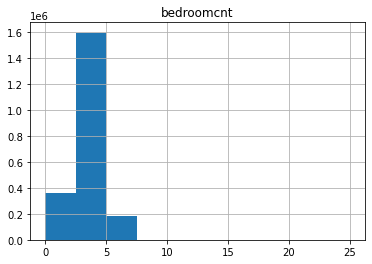

bathroomcnt


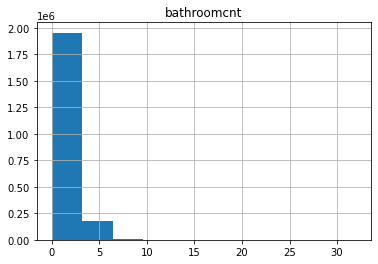

indoor_squarefeet


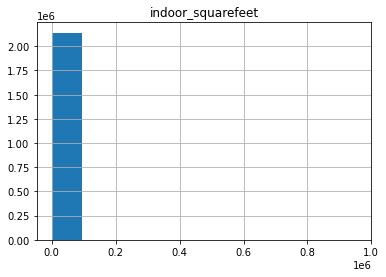

taxvalue


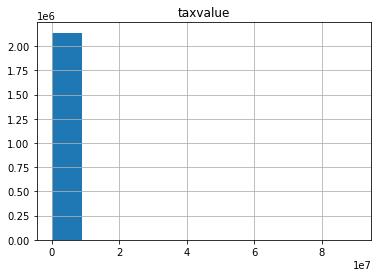

yearbuilt


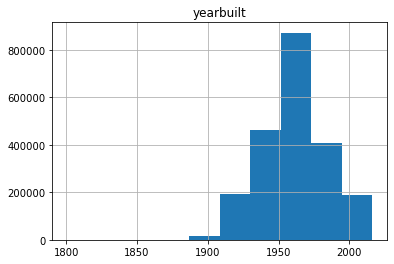

taxamount


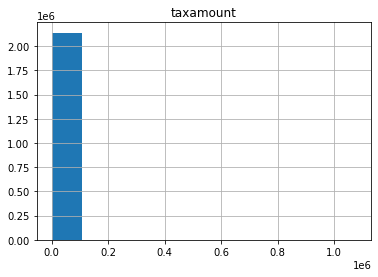

fips


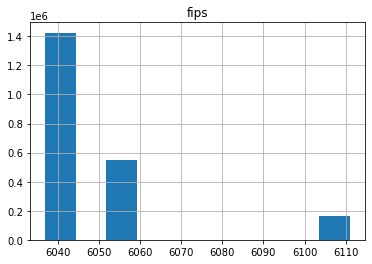

In [26]:
for col in houses.columns:
    print(col)
    plt.title(col)
    houses[col].hist()
    plt.grid(True)
    plt.show()

## Takeaways
There are indeed a lot of outliers except for yearbuilt and fips
* Set threshhold for outliers in (reference outliers shape in hist):
    - bedroomcnt: 8
    - bathroomcnt: 9
    - indoor_squarefeet: arbitrary number of 20,000
    - taxamount: associate to the corresponding indoor_squarefeet to see the proportion that is dropped
* I'll evaluate if the size of the remaining data is significant or not

In [27]:
# The proportion of houses that have 8 bedrooms and less

houses[houses.bedroomcnt <= 8].shape[0] / houses.shape[0]

0.9997724548939719

In [28]:
# The proportion of houses that have 8 bathrooms and less

houses[houses.bathroomcnt <= 9].shape[0] / houses.shape[0]

0.9996612521522169

In [29]:
# The proportion of houses that have 20_000 indoor_squarefeet and less

houses[houses.indoor_squarefeet <= 20_000].shape[0] / houses.shape[0]

0.9999551451125694

In [30]:
# Mean of tax value of houses corresponding to more than 18_000 sqft

houses[houses.indoor_squarefeet > 20_000].taxamount.mean()

231945.62822916664

In [31]:
# The proportion of houses that have tax value <= 18893736

houses[houses.taxamount <= 231946].shape[0] / houses.shape[0]

0.9998981420264597

## Takeaways
- The proportion obtained are still significant and won't denature the data
- I will filter the data through 8 bedrooms criterion its most restrictive one 

In [33]:
# Filtering the data through number of bedrooms

houses = houses[houses.bedroomcnt <= 8]
houses

,bedroomcnt,bathroomcnt,indoor_squarefeet,taxvalue,yearbuilt,taxamount,fips
4,4,2.0,3633,296425,2005,6941.39,6037
6,3,4.0,1620,847770,2011,10244.94,6037
7,3,2.0,2077,646760,1926,7924.68,6037
11,0,0.0,1200,5328,1972,91.60,6037
14,0,0.0,171,6920,1973,255.17,6037
...,...,...,...,...,...,...,...
2152856,4,4.0,4375,422400,2015,13877.56,6037
2152858,4,3.0,2262,960756,2015,13494.52,6059
2152859,4,4.5,3127,536061,2014,6244.16,6059
2152861,3,2.5,1974,424353,2015,5302.70,6059


In [ ]:
# Compiling the code for preparing my data

# Dropping null values
houses = properties_2017.dropna(axis = 0, how ='any')

# Dropping a column
houses = houses.drop(['propertylandusetypeid'], axis = 1)

# Renaming columns
cols_to_rename = {
    'calculatedfinishedsquarefeet': 'indoor_squarefeet',
    'taxvaluedollarcnt': 'taxvalue',
}

houses = houses.rename(columns=cols_to_rename)

# Converting the following columns to int
houses["bedroomcnt"] = houses["bedroomcnt"].astype(int)
houses["indoor_squarefeet"] = houses["indoor_squarefeet"].astype(int)
houses["taxvalue"] = houses["taxvalue"].astype(int)
houses["yearbuilt"] = houses["yearbuilt"].astype(int)
houses["fips"] = houses["fips"].astype(int)

# Filtering the data through number of bedrooms
houses = houses[houses.bedroomcnt <= 8]
houses